In [150]:
# Import modules

from music21 import *
import math
import numpy as np

In [13]:
m1 = stream.Stream()
m1.append(note.Note('C4', type="quarter"))
m1.show("text")

m2 = stream.Stream()
m2.insert(2, note.Note('D4', type="half"))
m2.show("text")

m3 = stream.Stream()
m3.insert(5, note.Note('E4', type="half"))
m3.show("text")

p = stream.Part()
#p.append(meter.TimeSignature('4/4'))
p.insert(0, m1)
p.insert(0, m2)
p.insert(0, m3)
#p = p.flatten()

p.show("text")

{0.0} <music21.note.Note C>
{2.0} <music21.note.Note D>
{5.0} <music21.note.Note E>
{0.0} <music21.stream.Stream 0x2953863b890>
    {0.0} <music21.note.Note C>
{0.0} <music21.stream.Stream 0x29538517290>
    {2.0} <music21.note.Note D>
{0.0} <music21.stream.Stream 0x29538503f90>
    {5.0} <music21.note.Note E>


In [141]:
# https://www.music21.org/music21docs/about/referenceCorpus.html#referencecorpus

beethoven = corpus.parse("beethoven/opus74.mxl")
excerpt = beethoven.measures(1, 13)
violin = excerpt.parts[0]

violin.show("text")
#violin.show("midi")


{0.0} <music21.instrument.Instrument 'P1: Violin I: '>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.expressions.TextExpression 'Poco Adagio'>
    {0.0} <music21.expressions.TextExpression 'sotto voce'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.key.Key of E- major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Note E->
    {2.0} <music21.note.Note G>
    {3.5} <music21.note.Note A->
{0.0} <music21.spanner.Slur <music21.note.Note E-><music21.note.Note A->>
{0.0} <music21.spanner.Slur <music21.note.Note E-><music21.note.Note A->>
{0.0} <music21.spanner.Slur <music21.note.Note E-><music21.note.Note B->>
{0.0} <music21.spanner.Slur <music21.note.Note B-><music21.note.Note A->>
{0.0} <music21.spanner.Slur <music21.note.Note A-><music21.note.Note G>>
{0.0} <music21.spanner.Slur <music21.note.Note G><music21.note.Note F>>
{0.0} <music21.dynamics.Crescendo <music21.note.Note E><music21.note.Note A->>
{0.0} <music21.spanner.Slur <music21.note.

{'E-': 4, 'G': 12, 'A-': 9, 'D-': 3, 'D': 3, 'C': 2, 'F': 10, 'B-': 5, 'E': 3, 'C-': 1}
{2.0: 3, 1.5: 2, 0.5: 12, 1.0: 18, 4.0: 1, 3.0: 1, 0.25: 12, 0.75: 1, 0.125: 2}


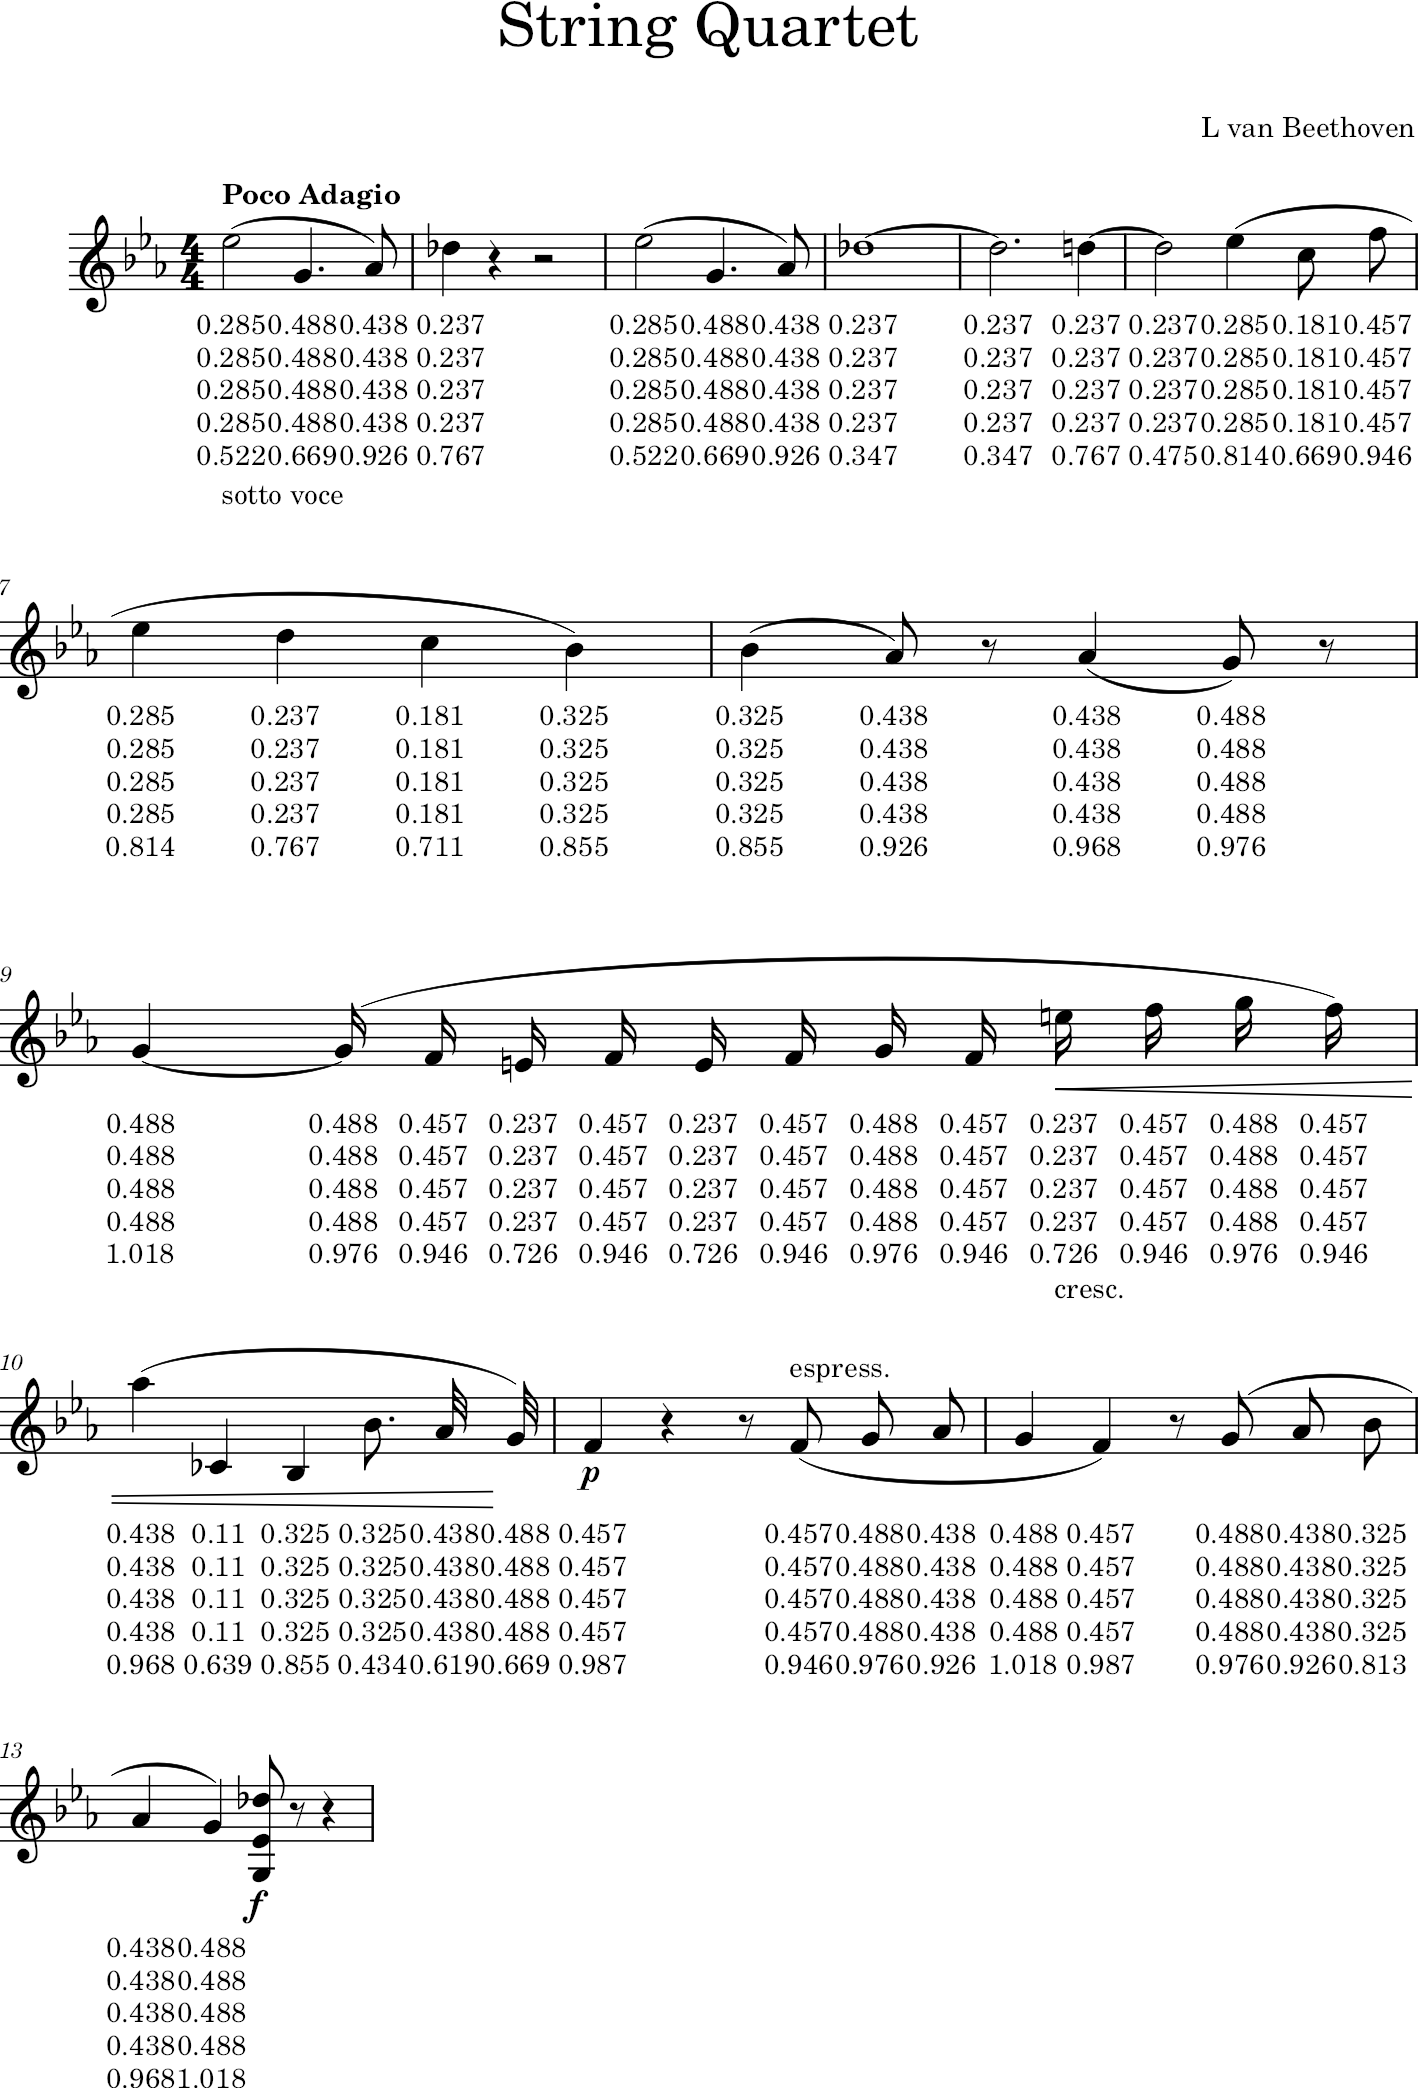

In [130]:
totalNotes = len(violin.recurse().getElementsByClass("Note"))
pitchCount = {}
durationCount = {}

# Doesn't check chords yet!
for n in violin.recurse().getElementsByClass("Note"):
    
    if n.name not in pitchCount:
        pitchCount[n.name] = 1
    else:
        pitchCount[n.name] += 1
    
    if n.duration.quarterLength not in durationCount:
        durationCount[n.duration.quarterLength] = 1
    else:
        durationCount[n.duration.quarterLength] += 1

print(pitchCount)
print(durationCount)

#violin.plot("histogram", "pitchClass")

def noteEntropy(note: note.Note) -> float:

    pitch = note.name
    duration = note.duration.quarterLength

    pitchEntropy = - (pitchCount[pitch] / totalNotes) * math.log2(pitchCount[pitch] / totalNotes)
    durationEntropy = - (durationCount[duration] / totalNotes) * math.log2(durationCount[duration] / totalNotes)

    return pitchEntropy + durationEntropy

def streamEntropy(stream: stream.Stream) -> float:

    pitchEntropy = sum([noteEntropy(n) for n in stream.recurse().getElementsByClass("Note")])
    
    return pitchEntropy


for thisNote in violin.recurse().getElementsByClass("Note"):
    thisNote.addLyric(round(noteEntropy(thisNote),3))

violin.show()

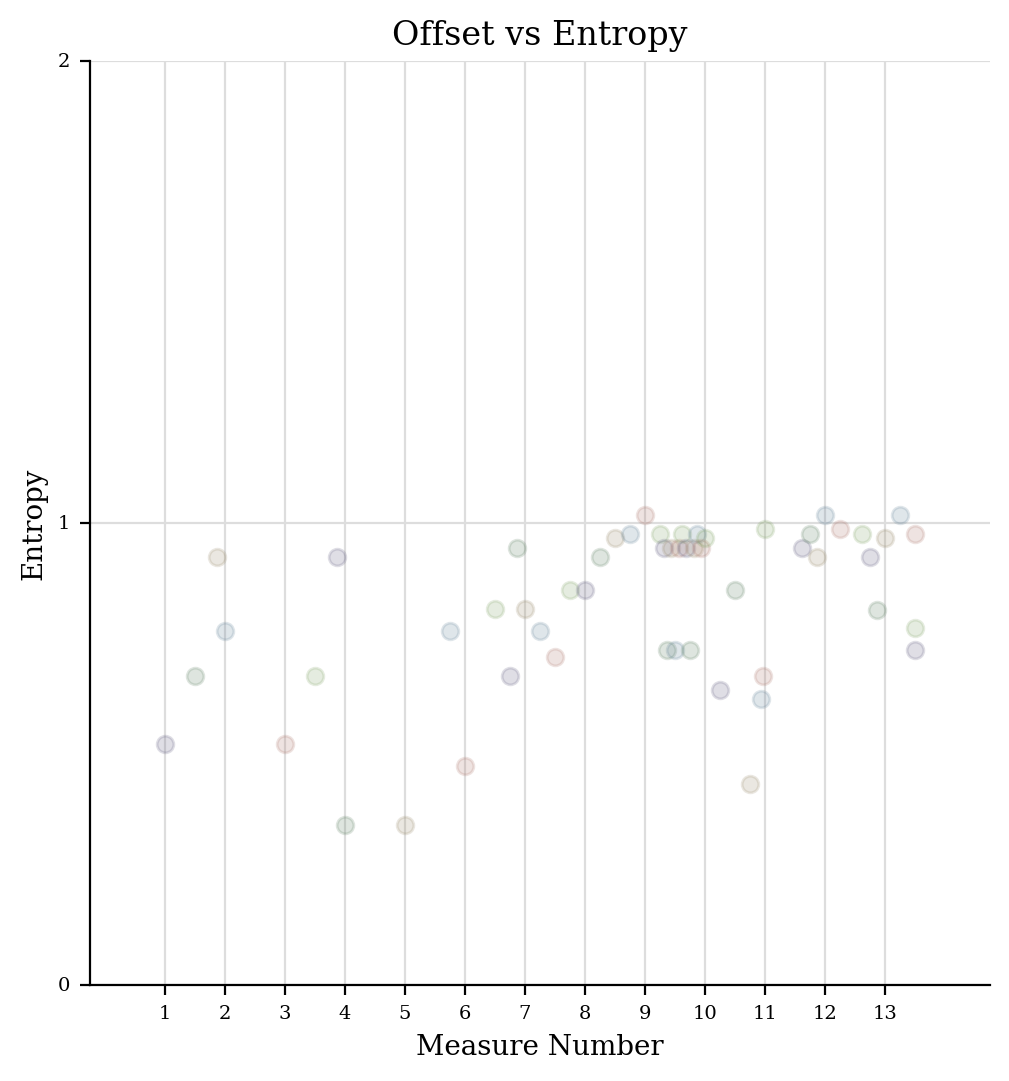

In [131]:
class EntropyAxis(graph.axis.Axis):
    labelDefault = 'Entropy'

    def extractOneElement(self, el, formatDict):
        if hasattr(el, 'name'):
            return noteEntropy(el)
        
plotS = graph.plot.Scatter(violin)

plotS.title = 'Offset vs Entropy'
plotS.axisX = graph.axis.OffsetAxis(plotS, 'x')
plotS.axisY = EntropyAxis(plotS, 'y')

plotS.run()

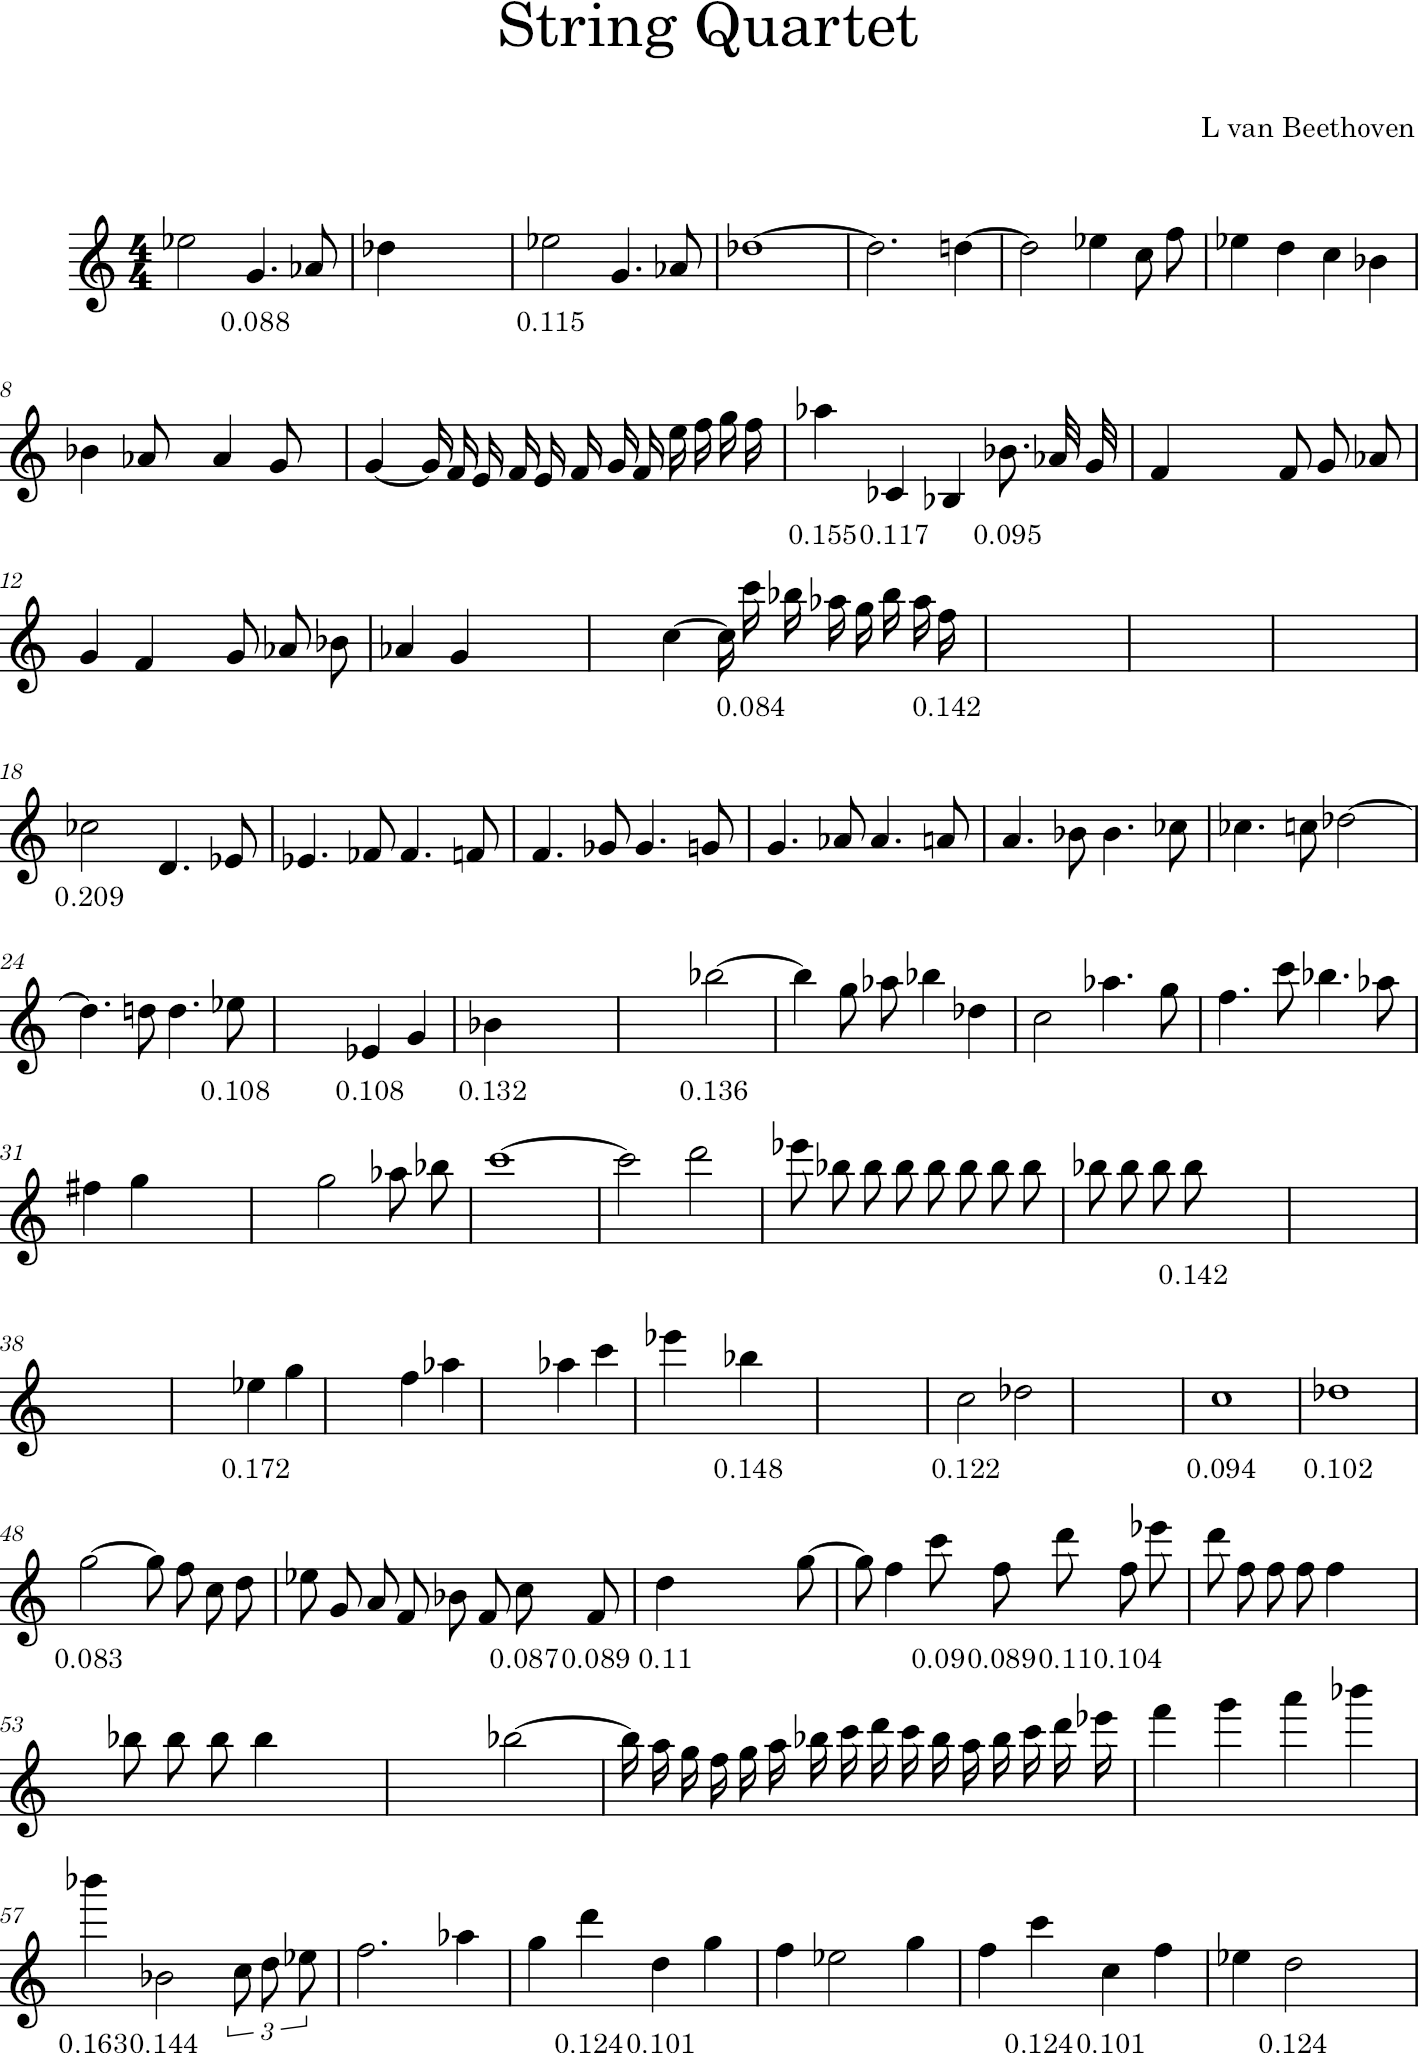

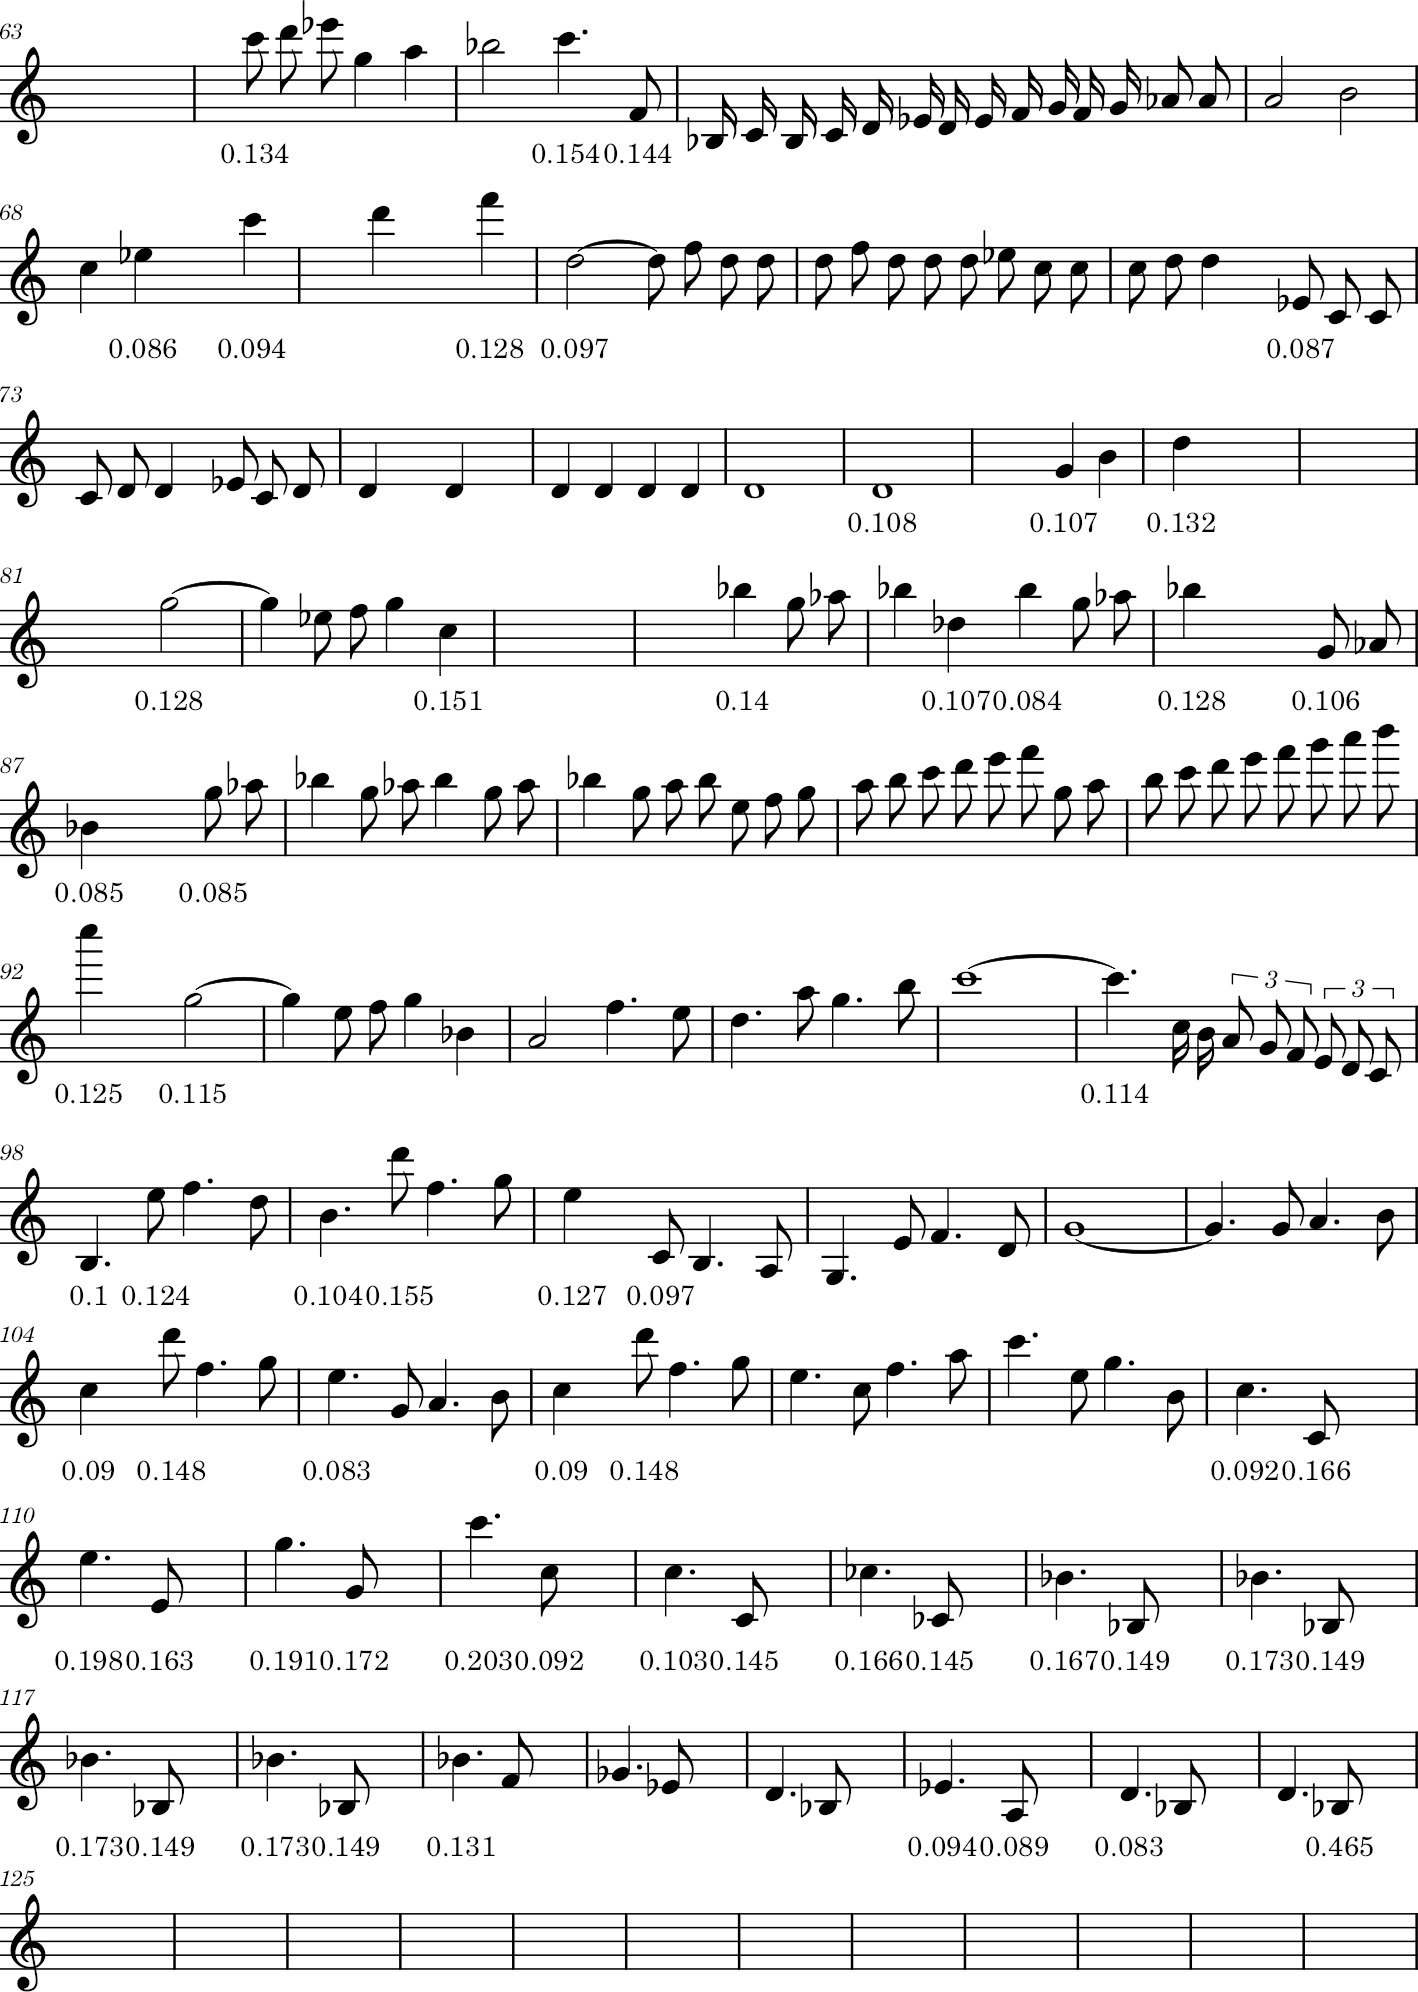

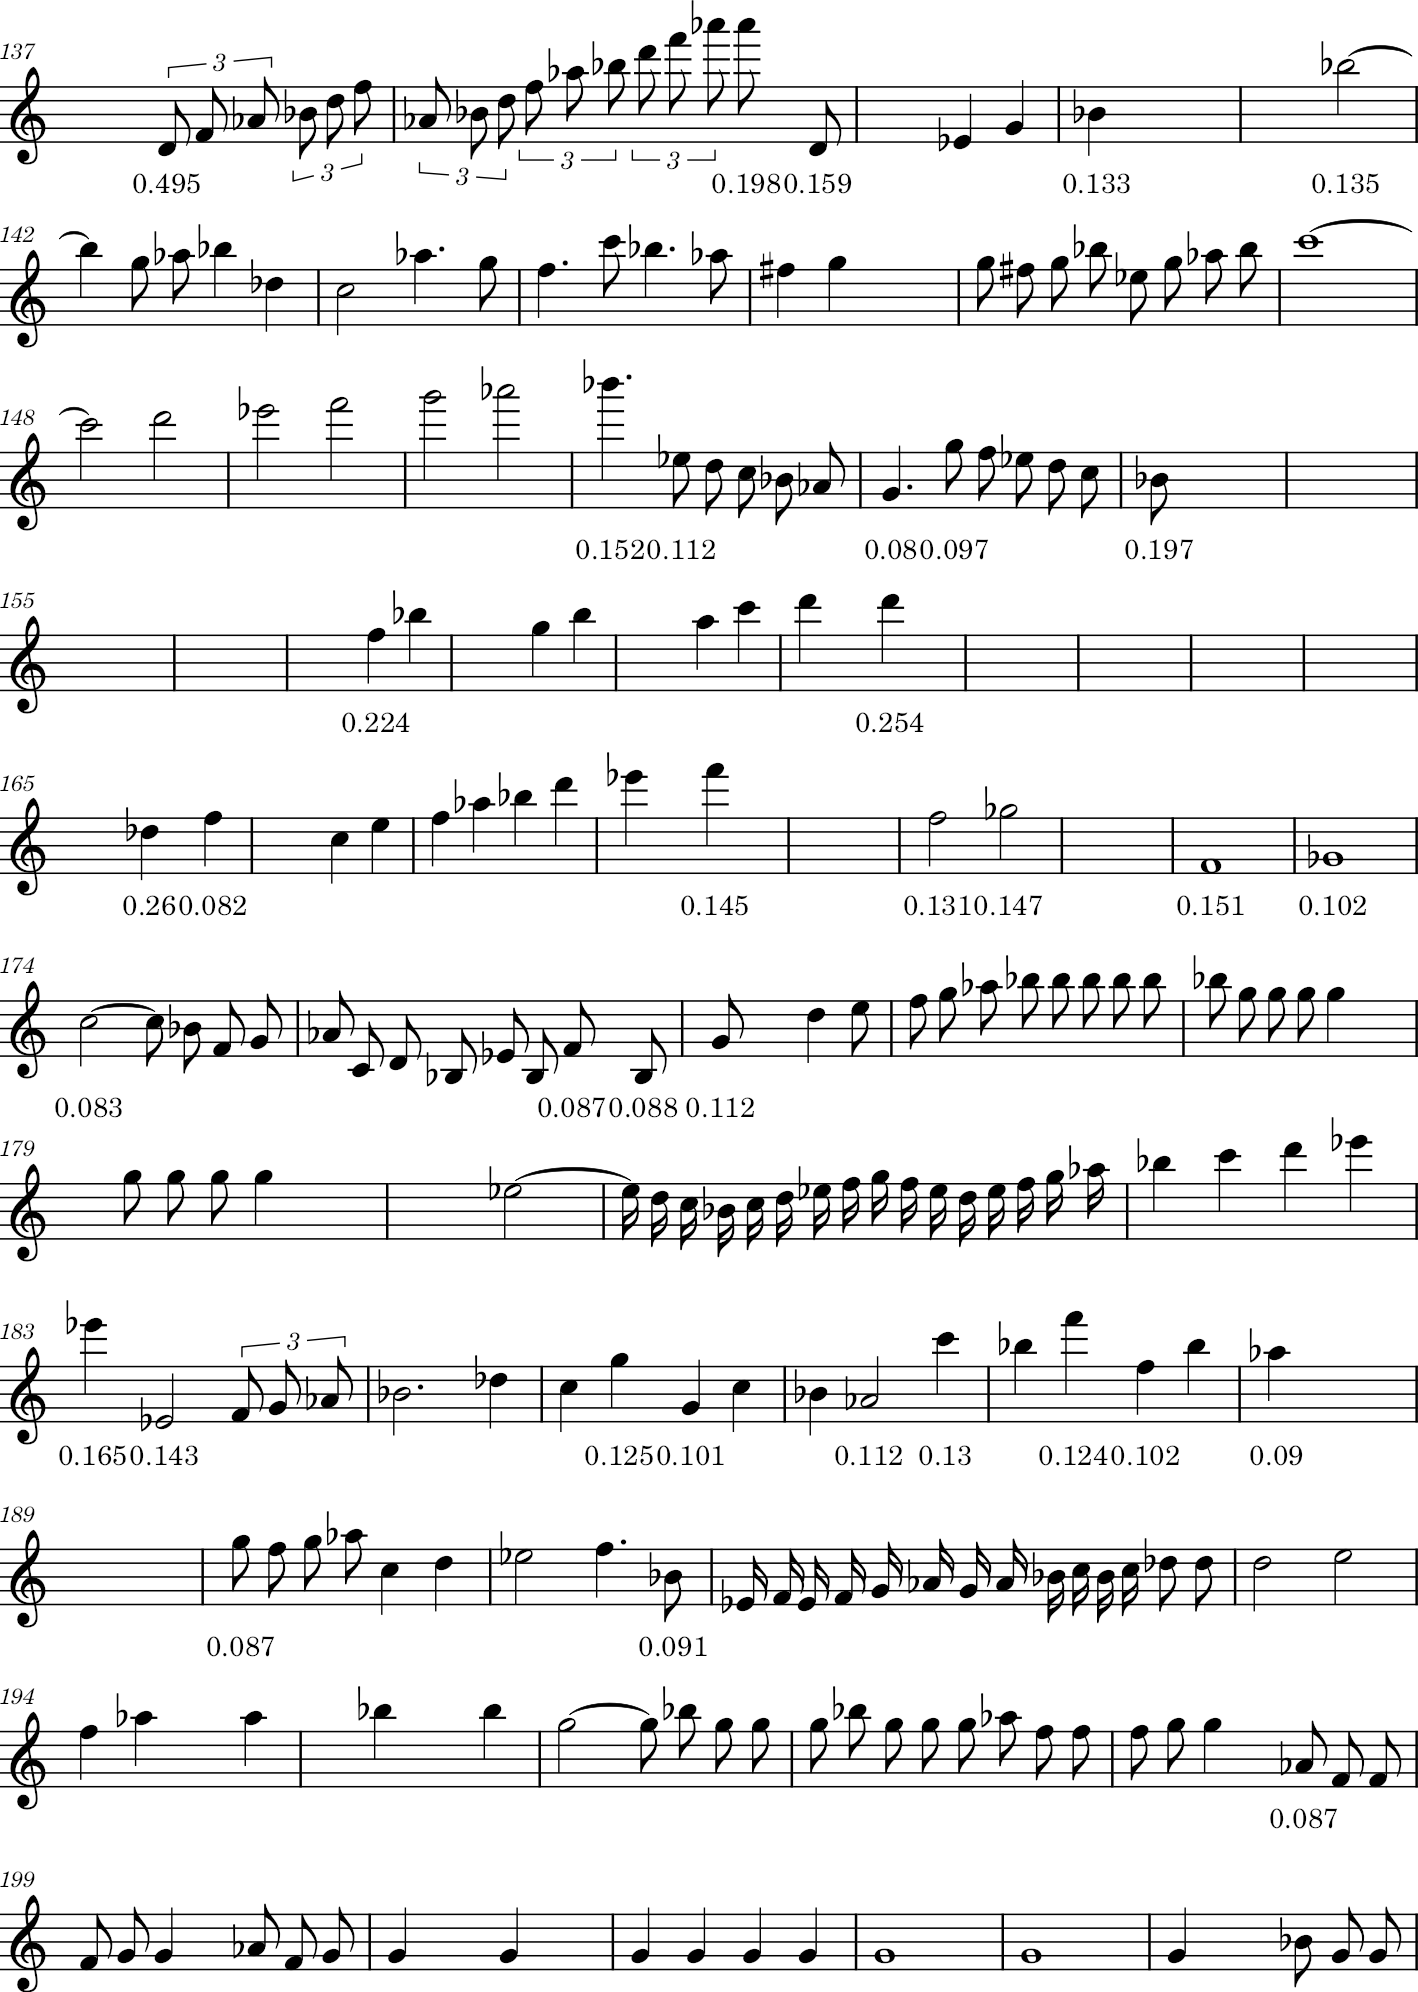

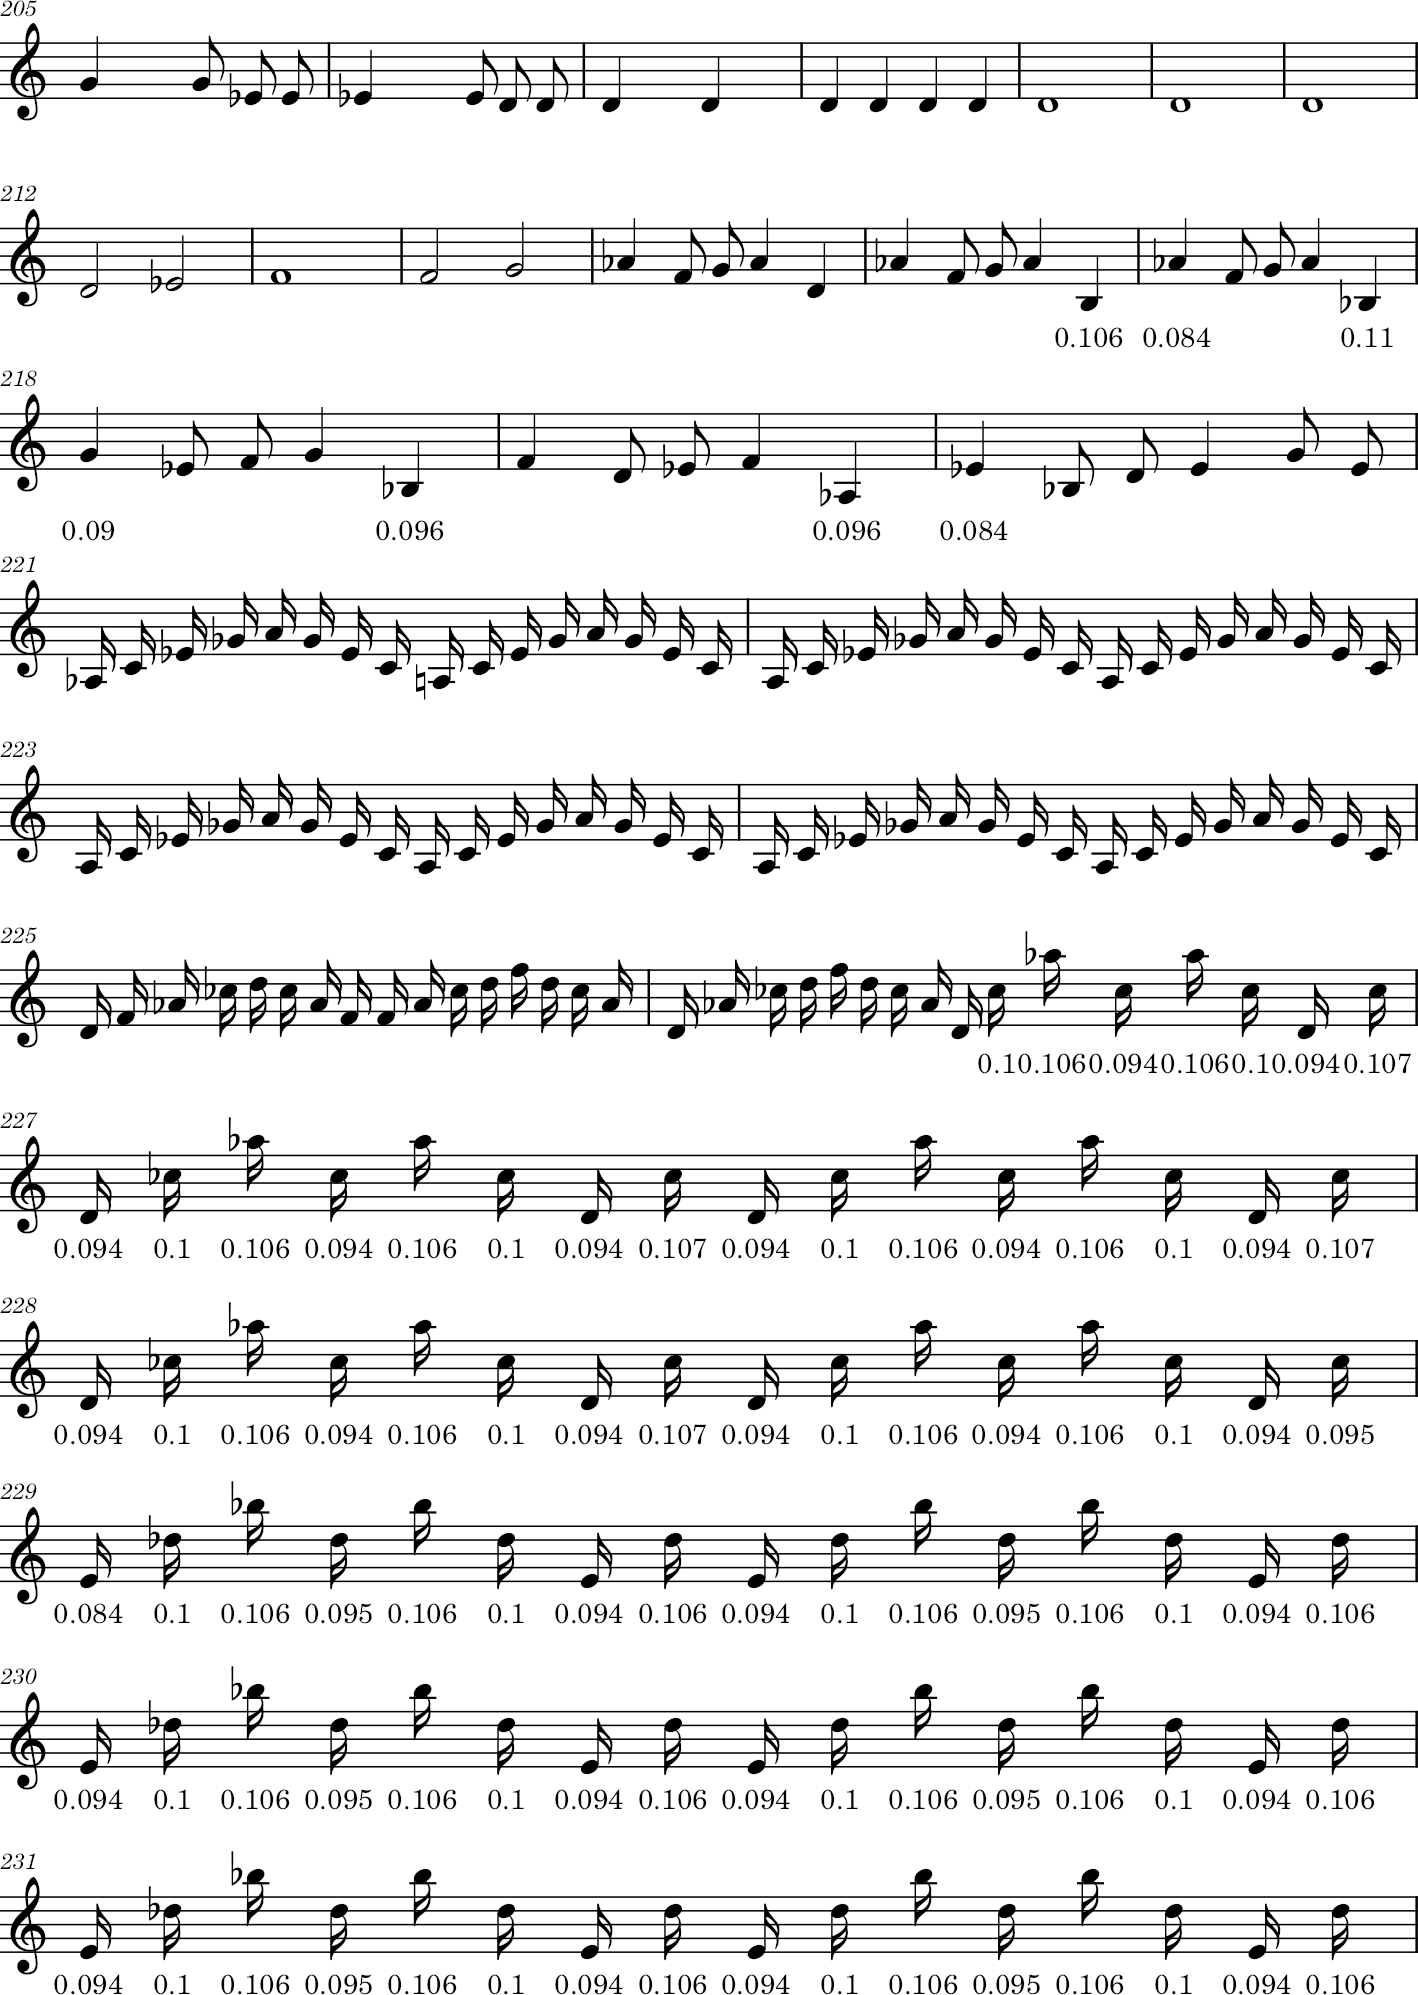

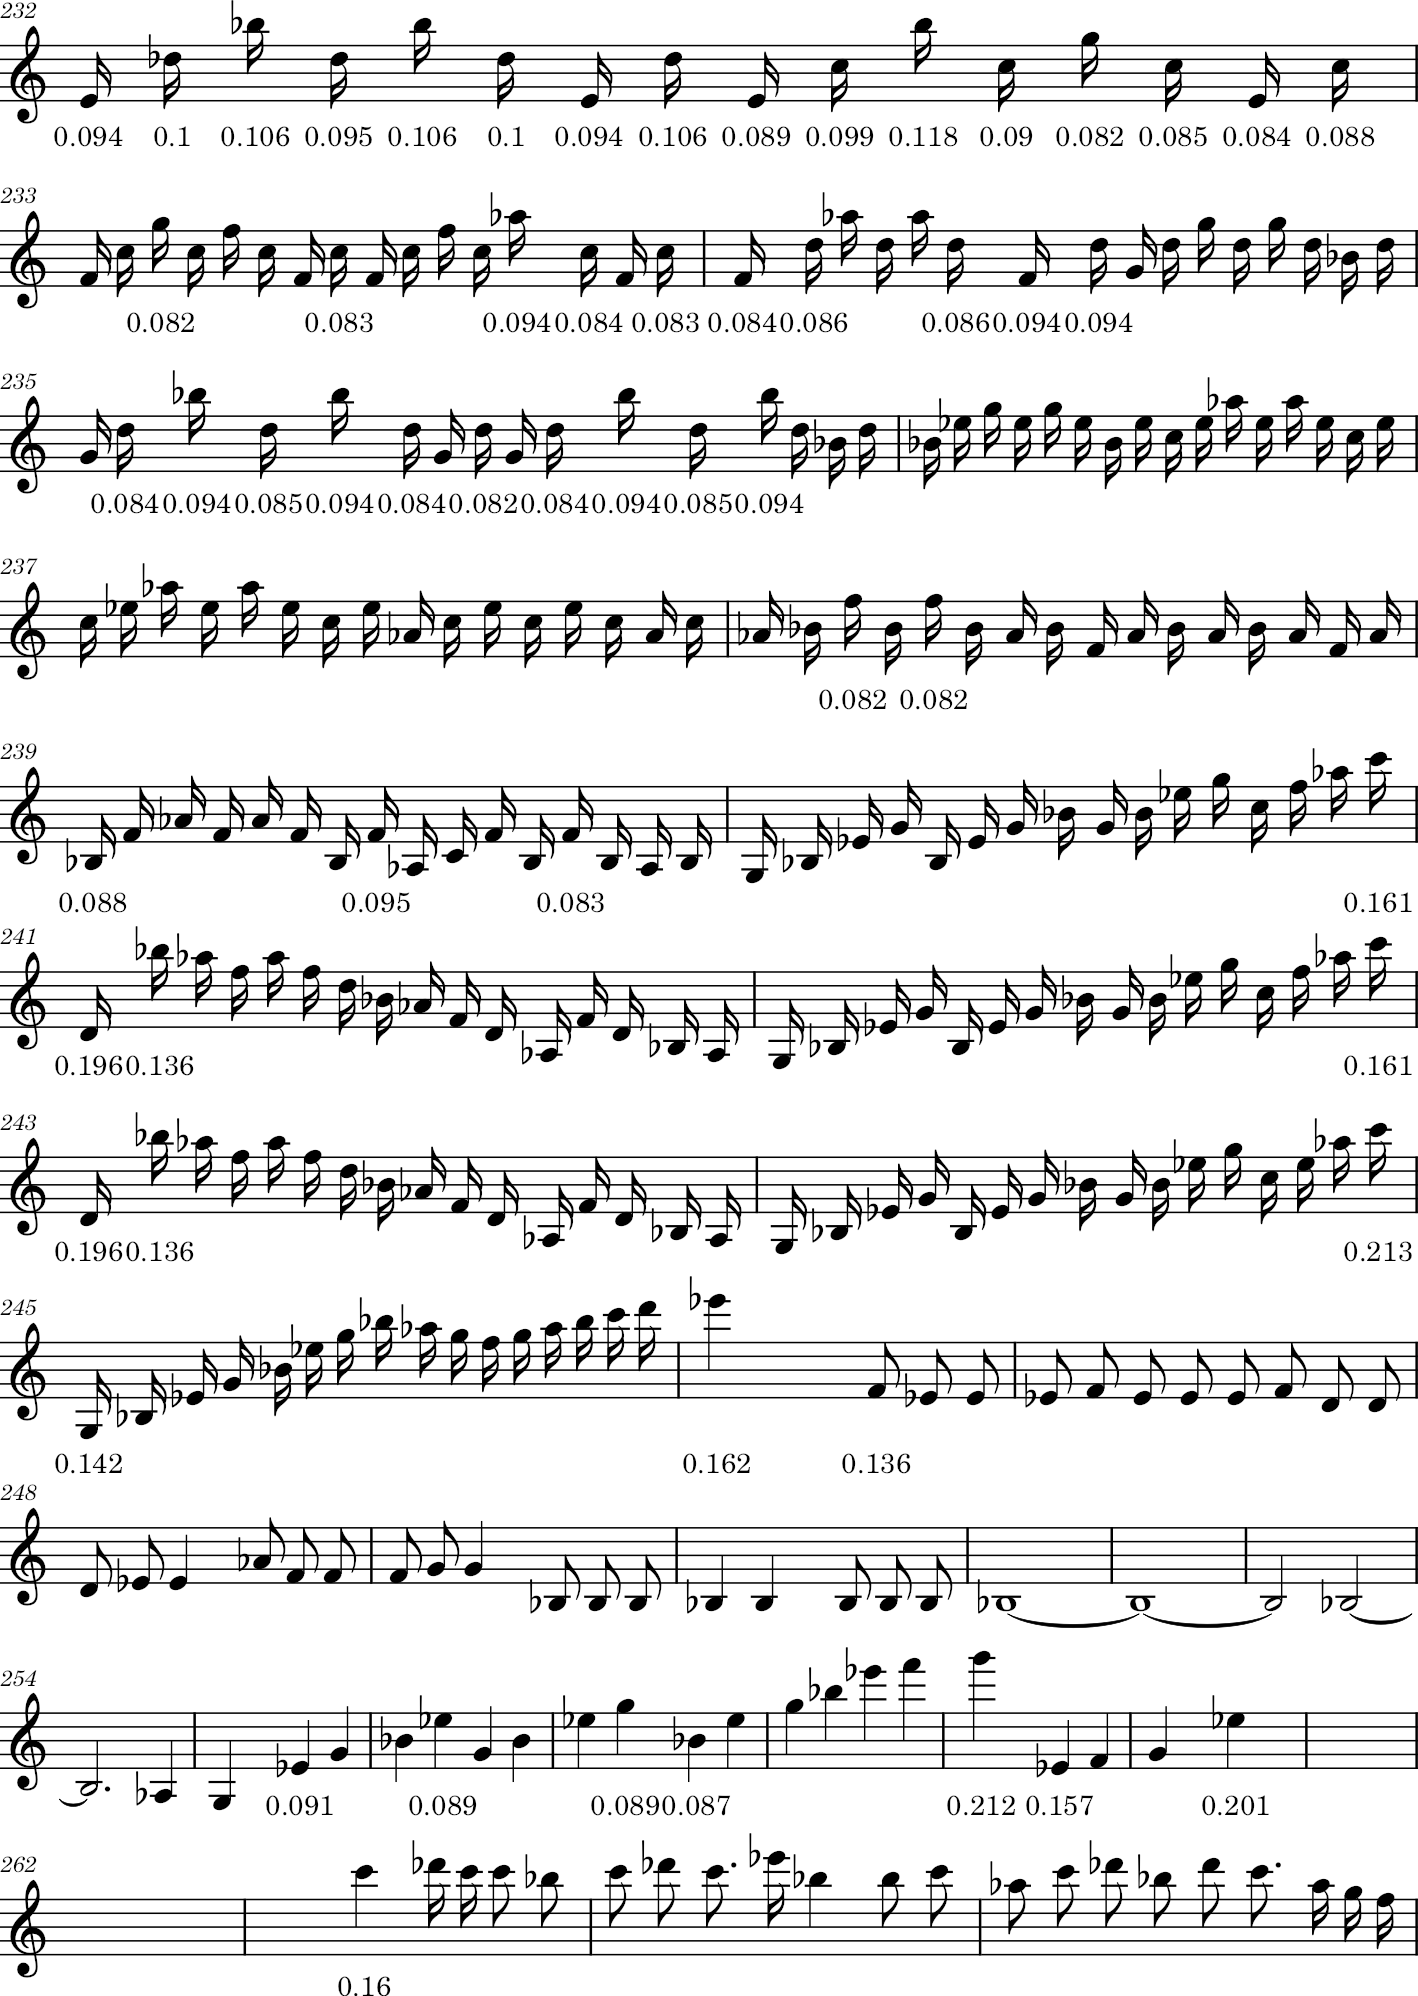

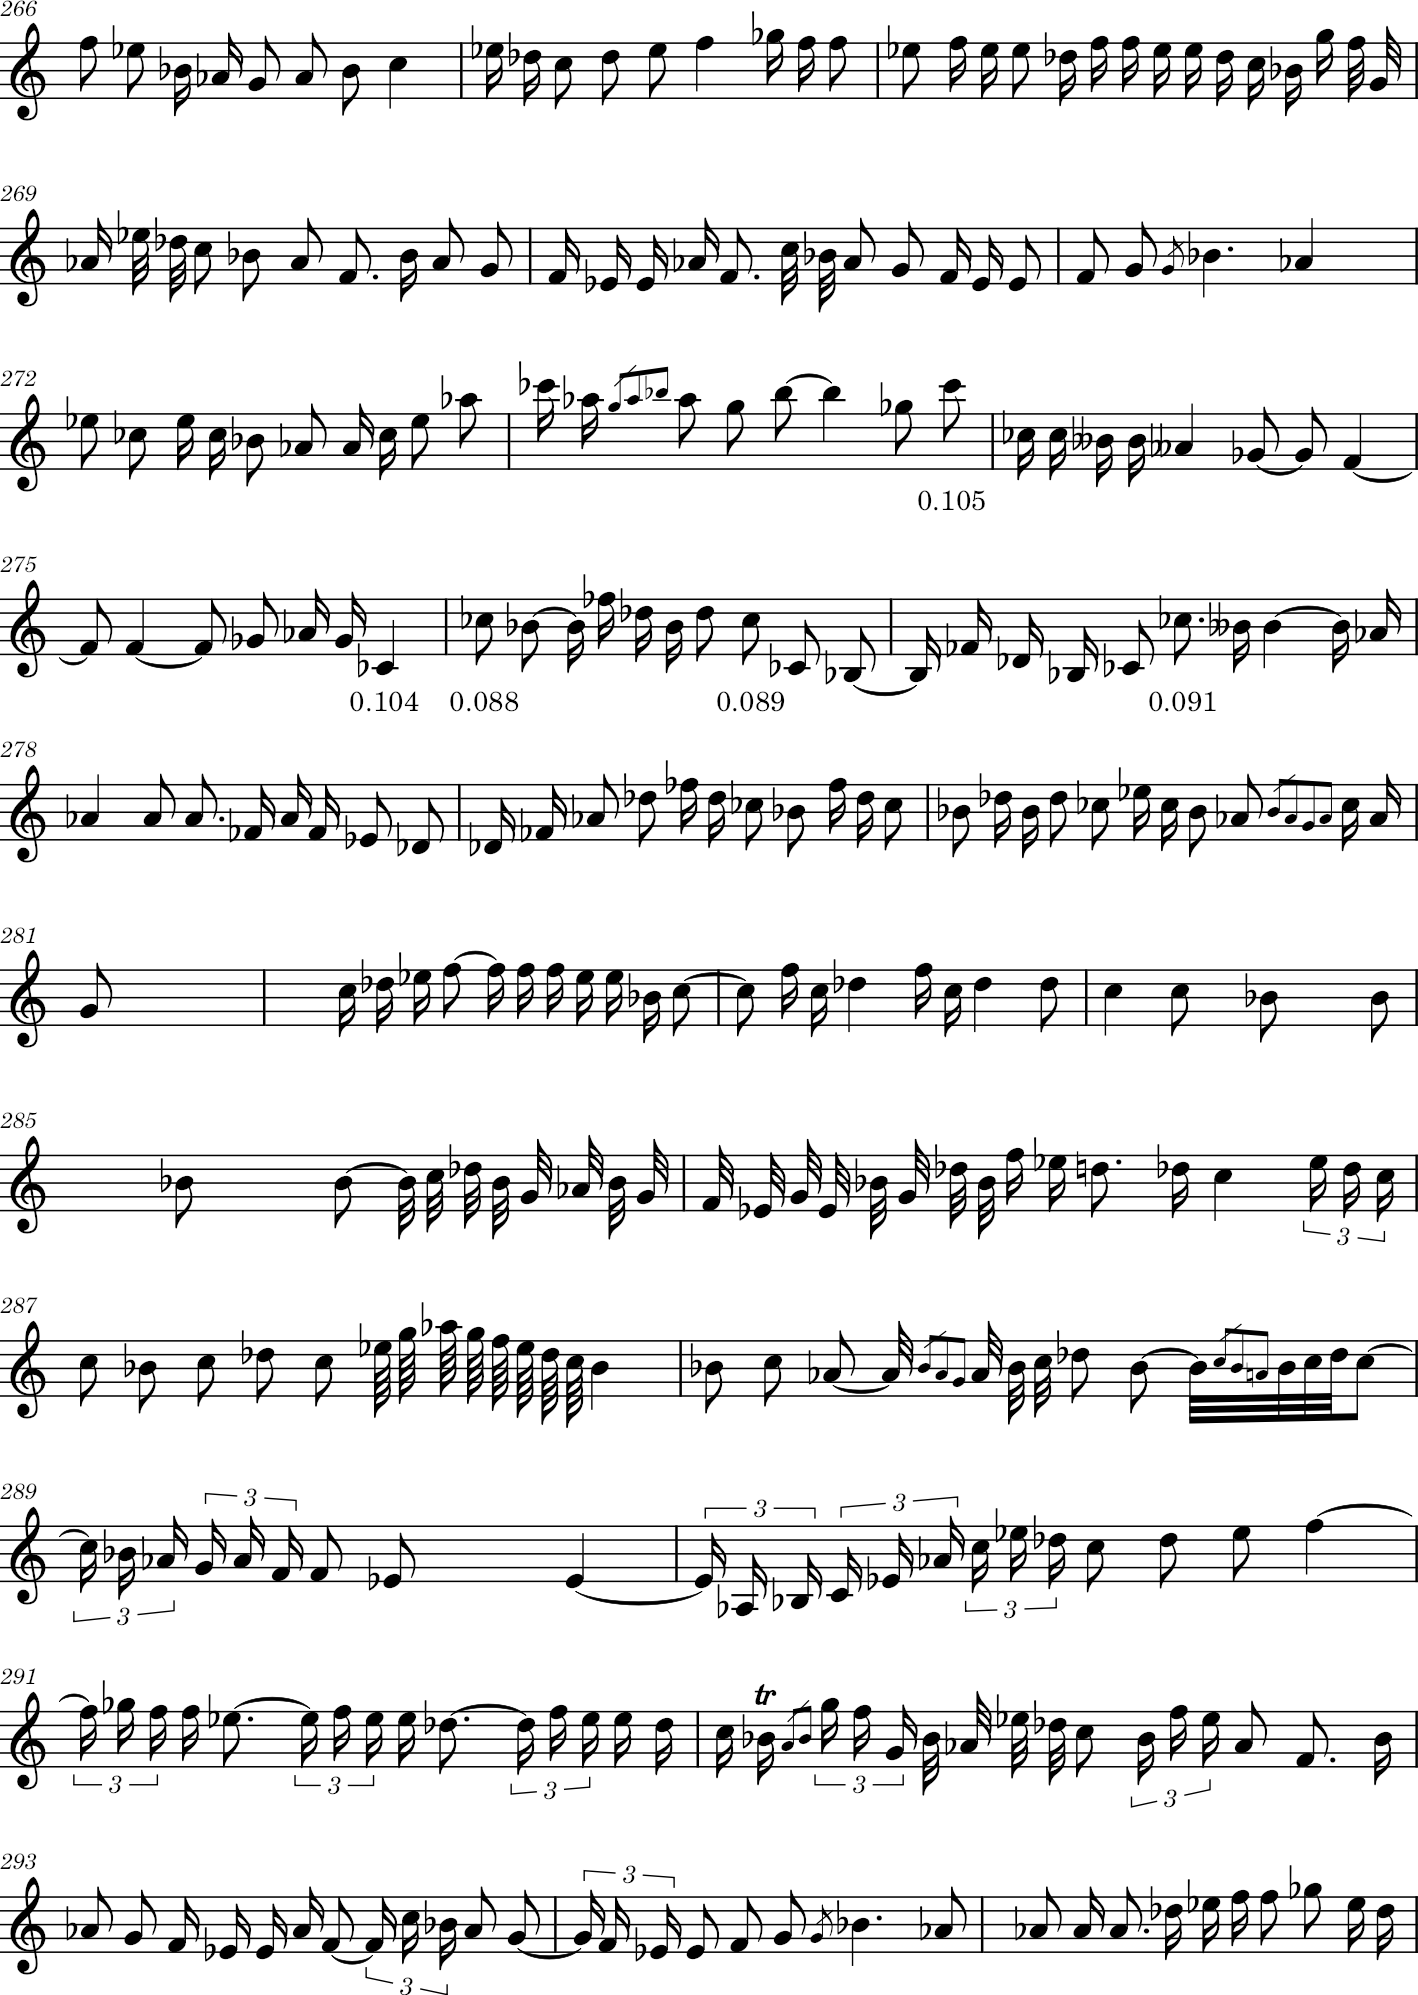

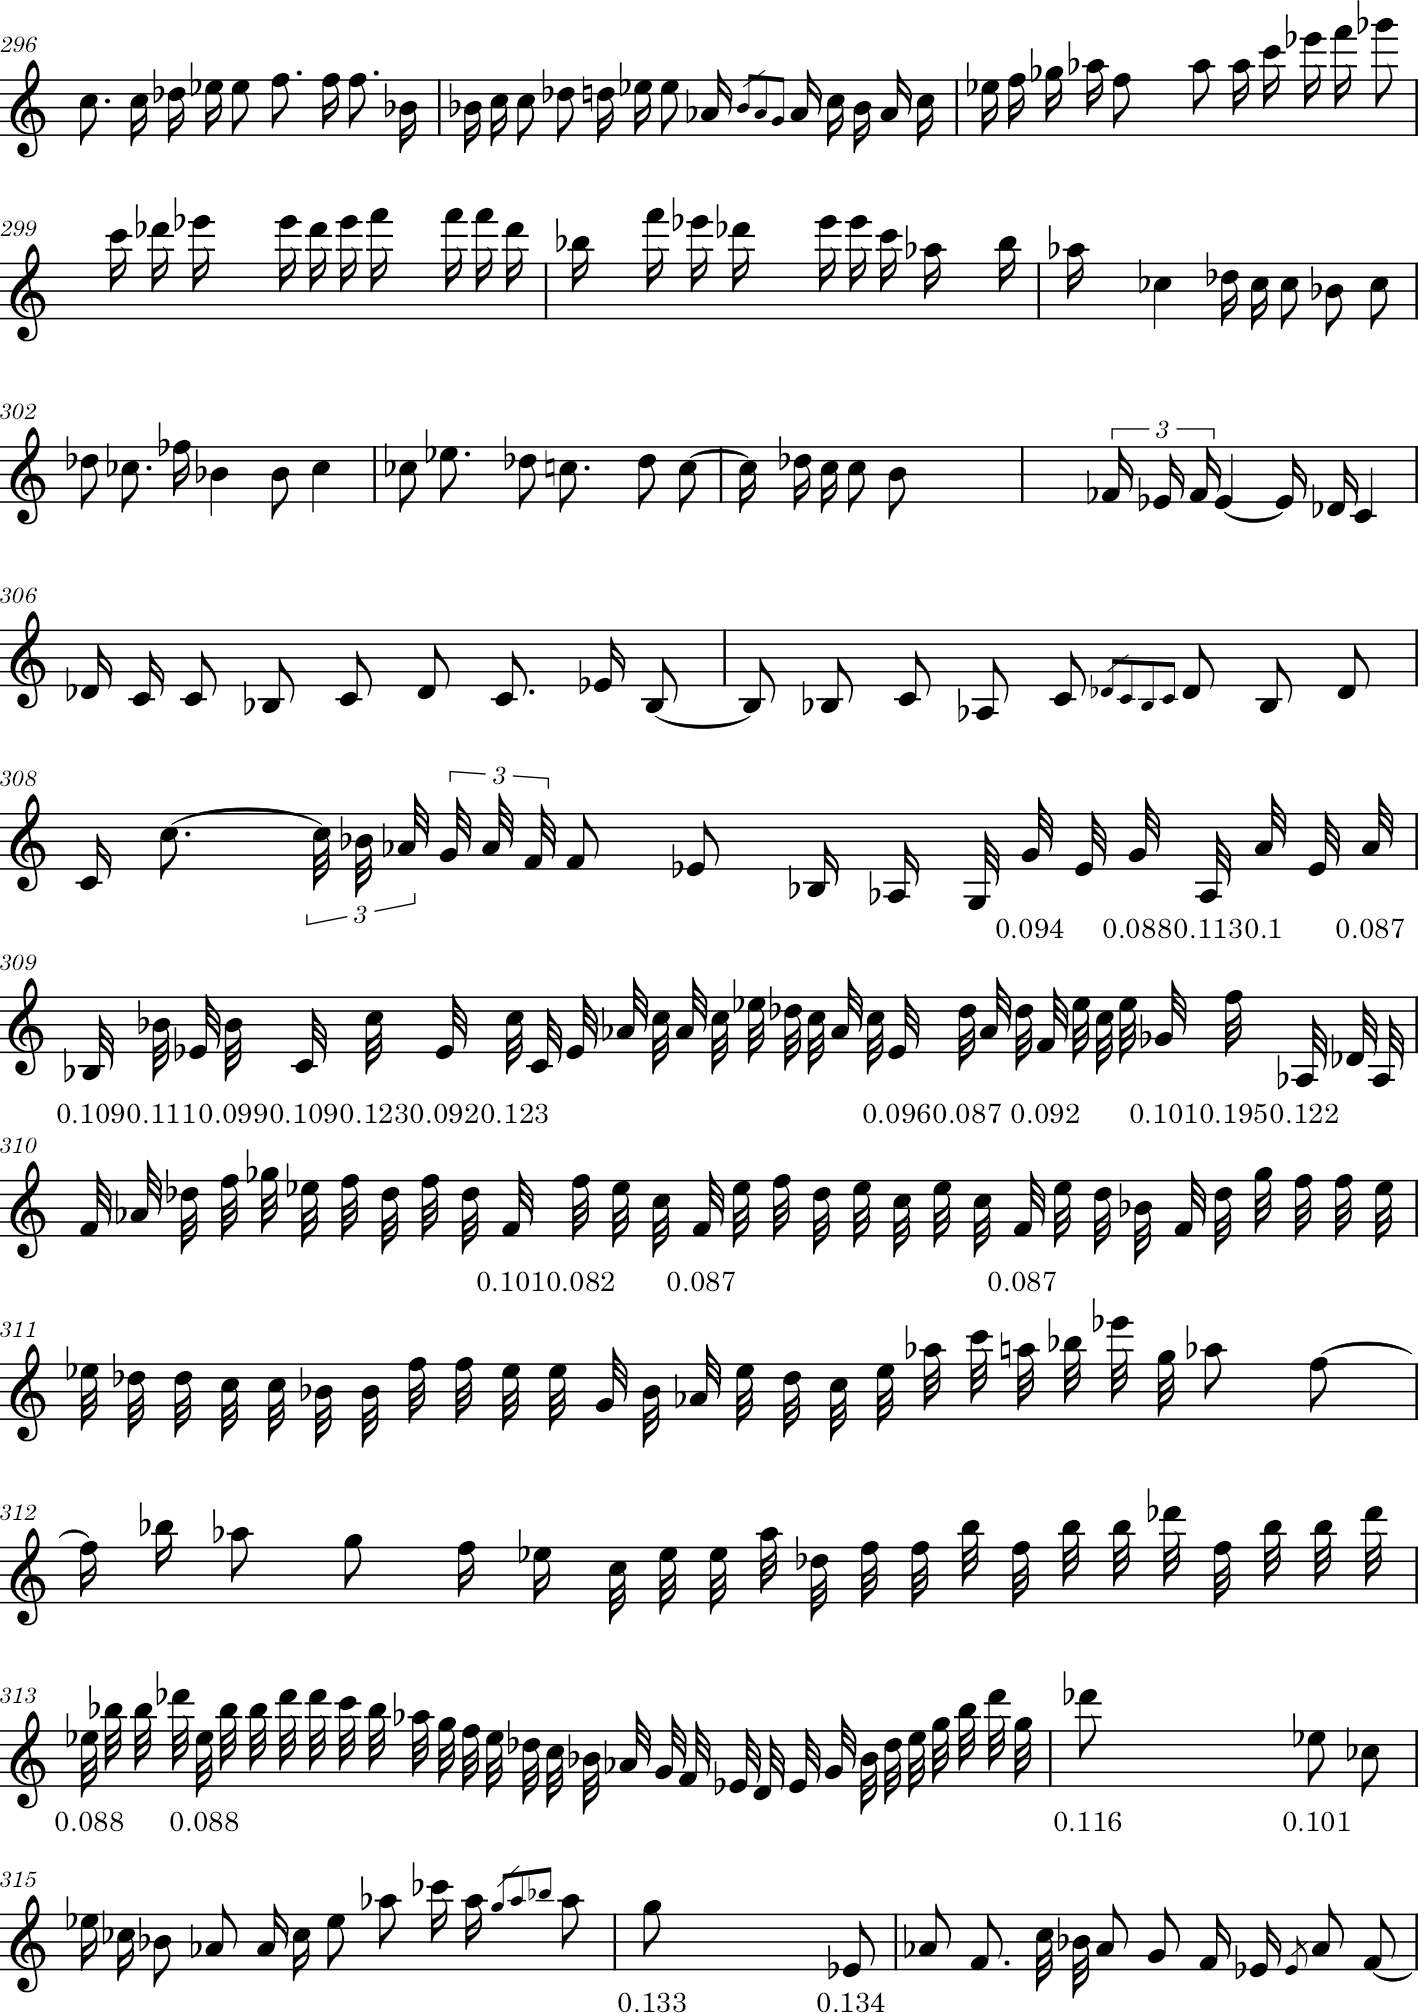

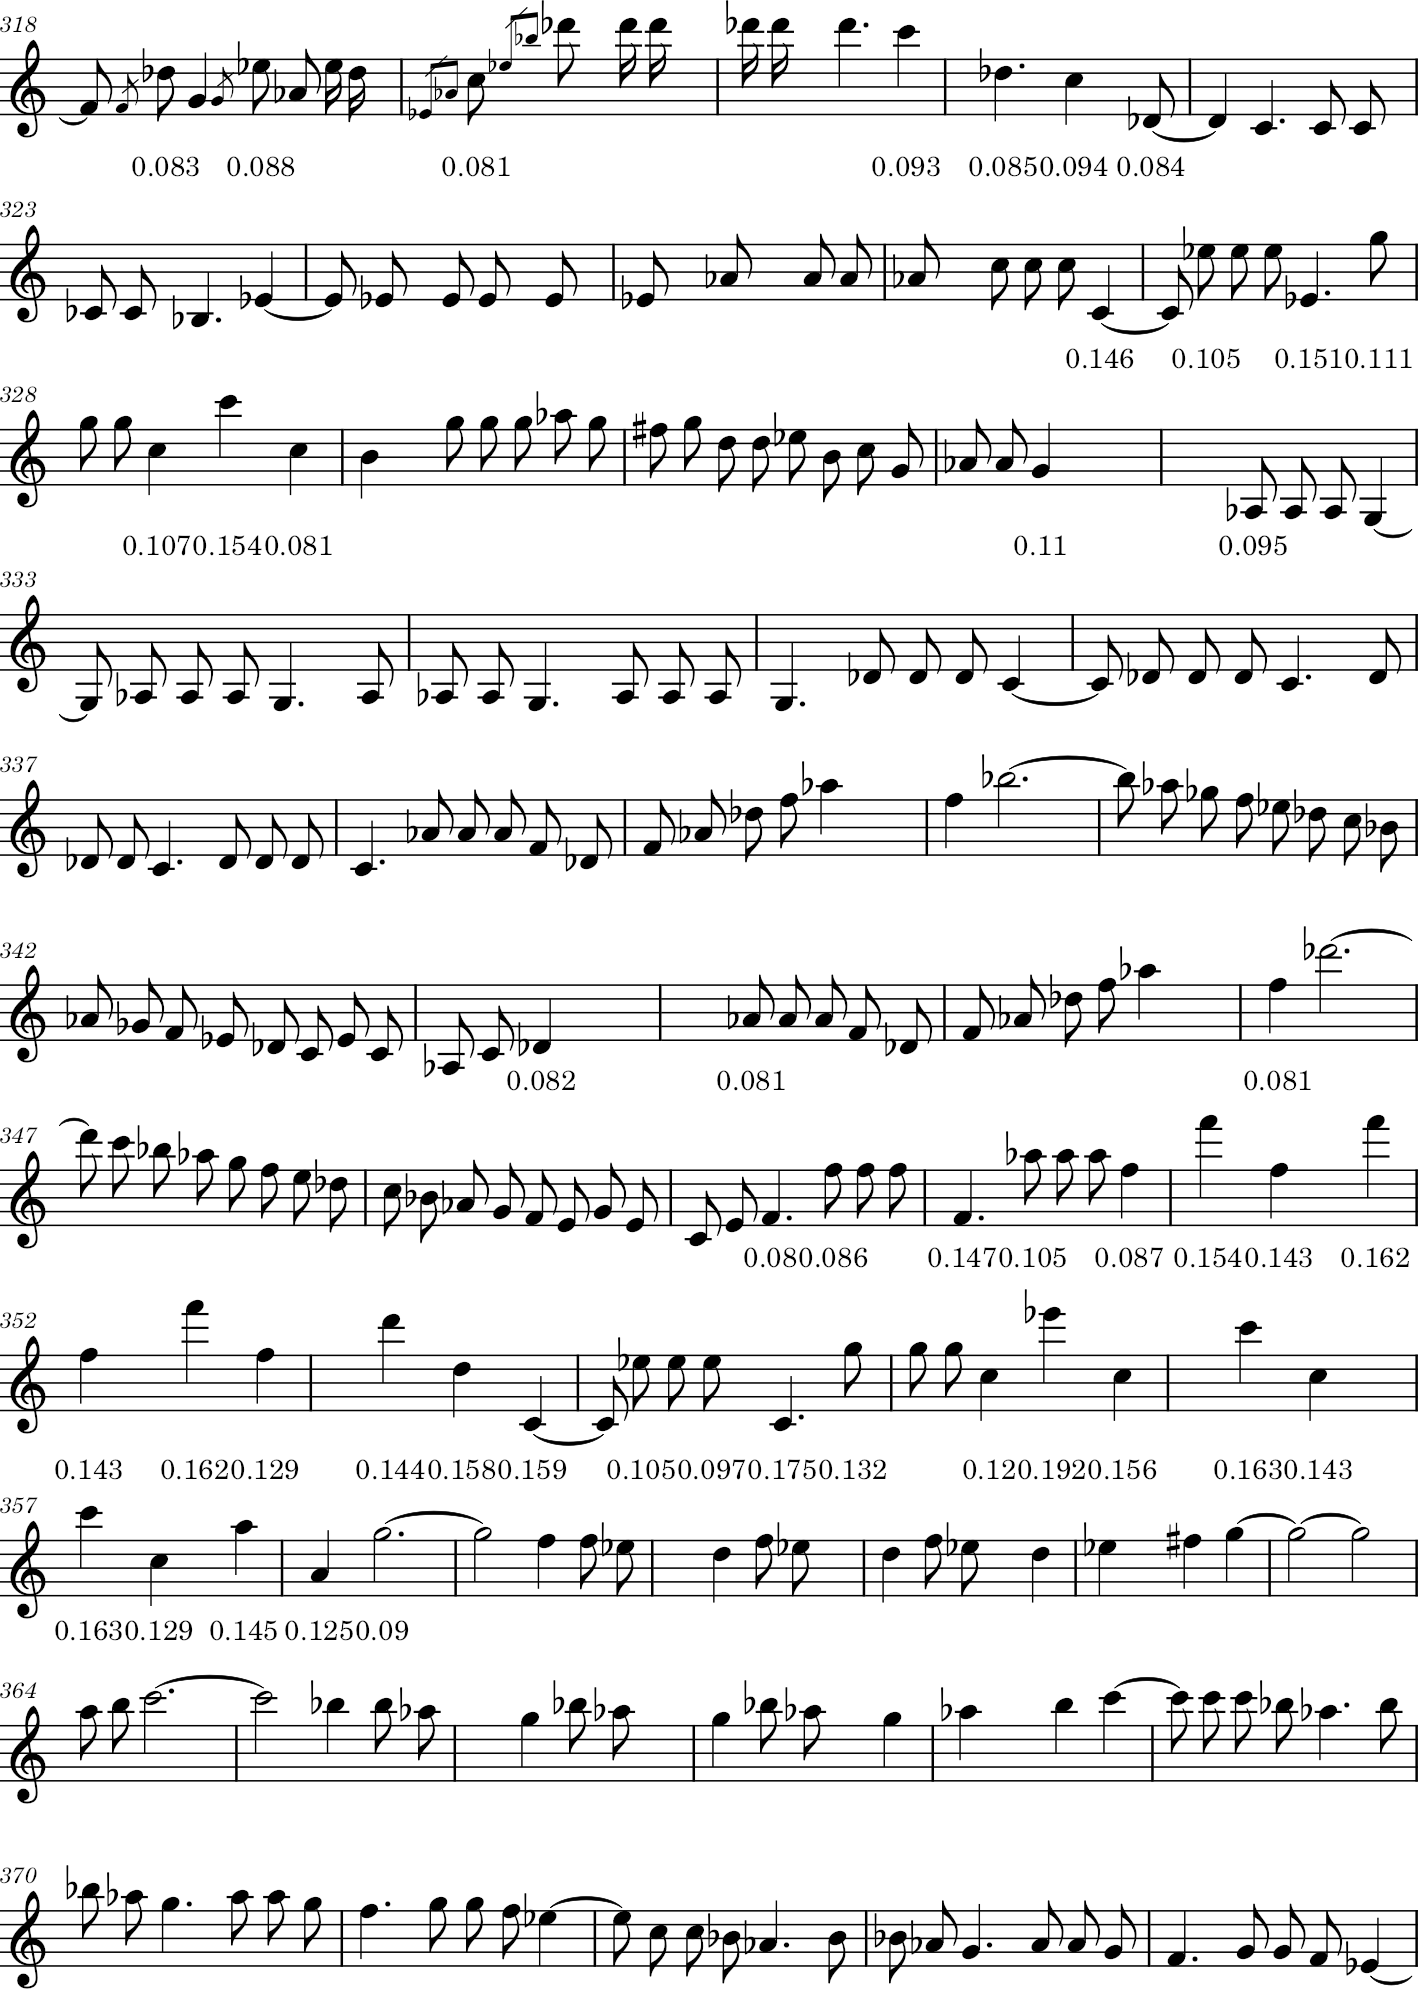

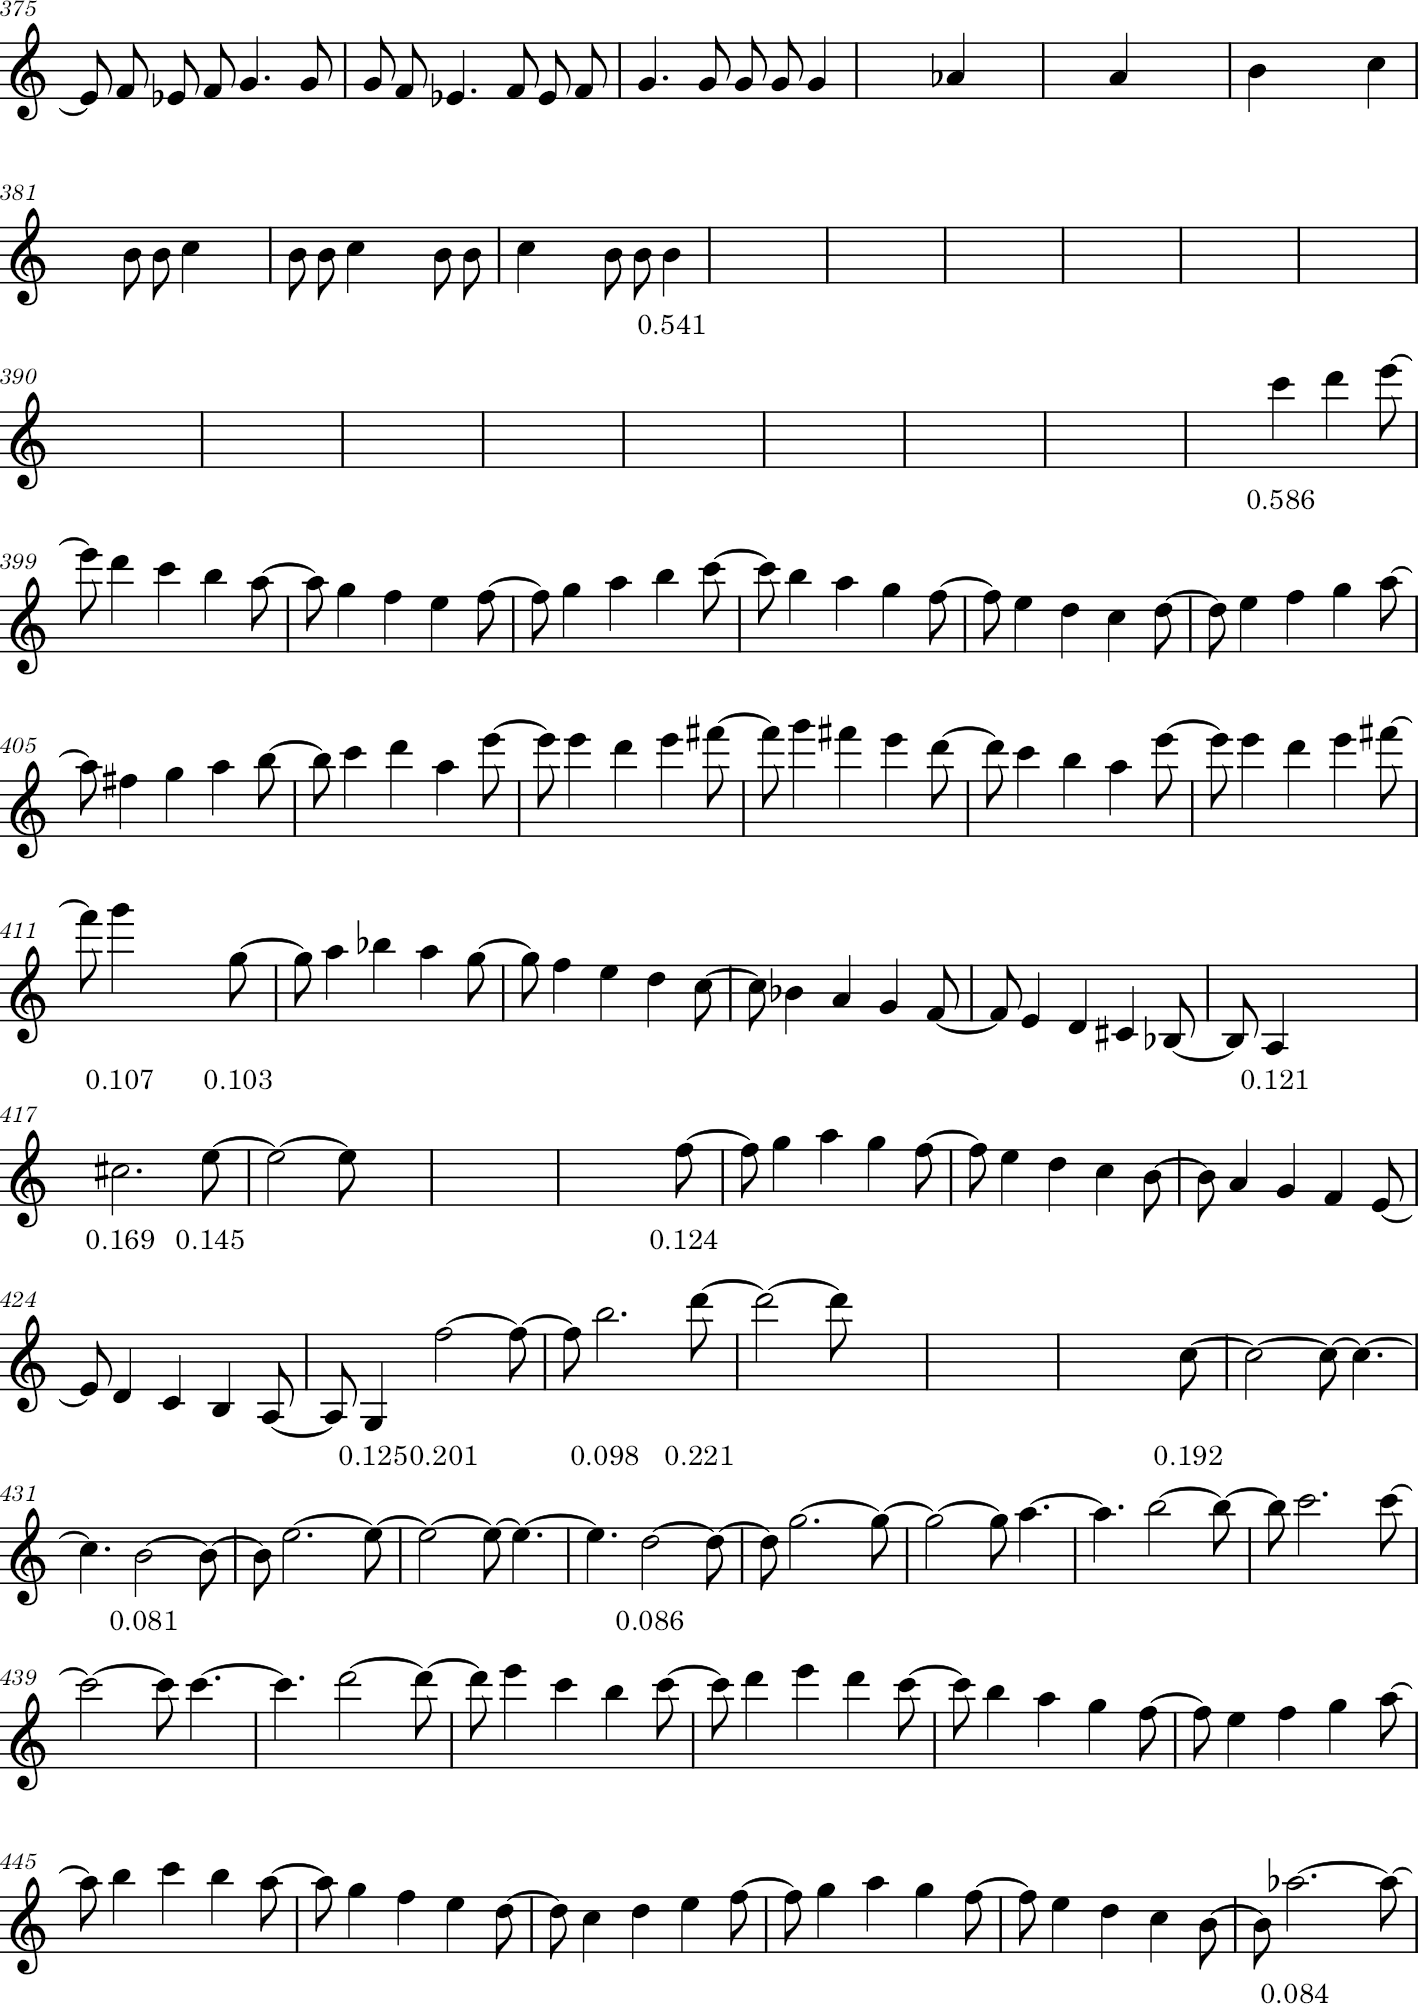

In [171]:
# Boundary detection

beethoven = corpus.parse("beethoven/opus74.mxl")
excerpt = beethoven.measures(1, 13)
violin = excerpt.parts[0]

def normalise(data: np.array) -> np.array:
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def pitchDegree(n1: note.Note, n2: note.Note) -> float:
    return abs(n1.pitch.ps - n2.pitch.ps) / (n1.pitch.ps + n2.pitch.ps)

def offsetDegree(n1: note.Note, n2: note.Note, stream: stream.Stream) -> float:
    
    return abs(n1.getOffsetInHierarchy(stream) - n2.getOffsetInHierarchy(stream)) / (n1.getOffsetInHierarchy(stream) + n2.getOffsetInHierarchy(stream))

def boundaryDetection(stream: stream.Stream, threshold: float) -> list[int]:

    noteStream = stream.recurse().getElementsByClass("Note").stream()
    pitchStrengths = np.empty(len(noteStream))
    offsetStrengths = np.empty(len(noteStream))

    for i,n in enumerate(noteStream):
        if i == 0 or i == len(noteStream) - 1:
            pitchStrengths[i] = 0
            offsetStrengths[i] = 0
            continue

        pitchStrengths[i] = n.pitch.ps * (pitchDegree(noteStream[i-1], n) + pitchDegree(n, noteStream[i+1]))
        offsetStrengths[i] = n.getOffsetInHierarchy(noteStream) * (offsetDegree(noteStream[i-1], n, noteStream) + offsetDegree(n, noteStream[i+1], noteStream))
    
    pitchStrengths = normalise(pitchStrengths)
    offsetStrengths = normalise(offsetStrengths)

    for i,n in enumerate(noteStream):
        total = 0.25*pitchStrengths[i] + 0.5*offsetStrengths[i]

        if total >= threshold:
            n.addLyric(round(total, 3))

    return noteStream

boundaries = boundaryDetection(beethoven.parts[0], 0.08)
boundaries.show()


In [114]:
# Create phrases

boundaries = [(0,4), (8,18), (19,21), (22,27), (28,31), (32,35.75), (36,40), (42.5,45), (46,50)]

#phrases = [violin.getElementsByOffset(start, end).stream().flatten() for (start, end) in boundaries]

phrases = []
n = 1
for (start, end) in boundaries:
    phrase = violin.getElementsByOffset(start, end).stream().flatten()
    
    phrase.id = n
    n += 1

    phrase.entropy = streamEntropy(phrase)
    
    phrases.append(phrase)


for p in phrases:
    print(p.id, p.entropy)

1 -1.4482413381567776
2 -1.923104094012924
3 -1.1602728114162244
4 -1.0277236168725965
5 -1.6889913389593447
6 -5.409478822849234
7 -3.9644449804749717
8 -2.196610769561028
9 -0.926160751140928


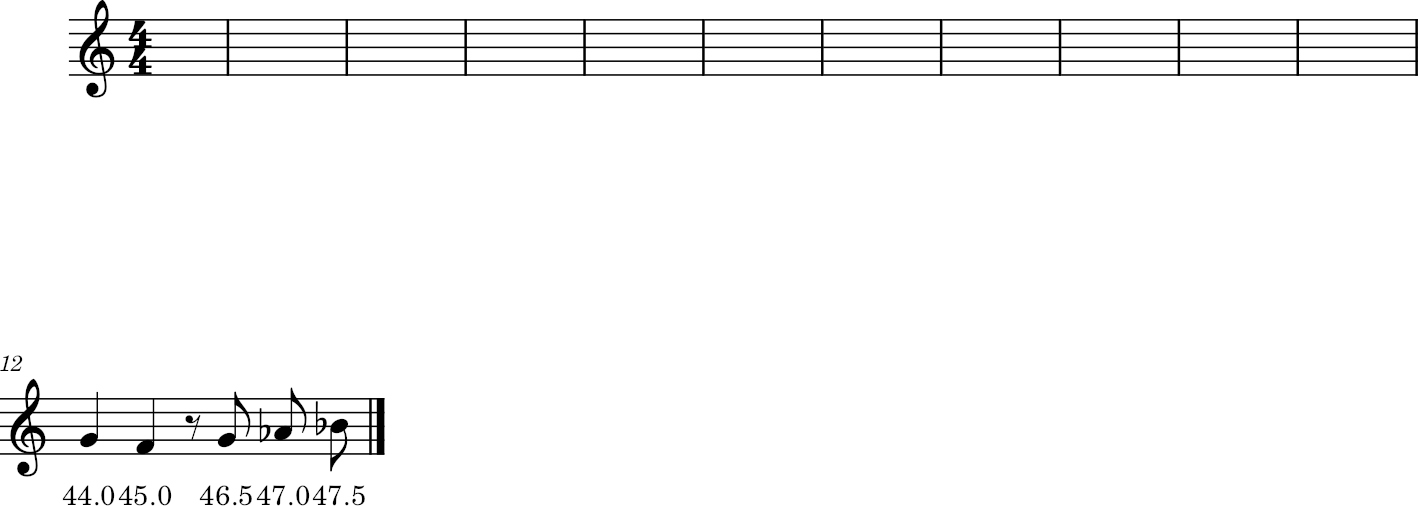

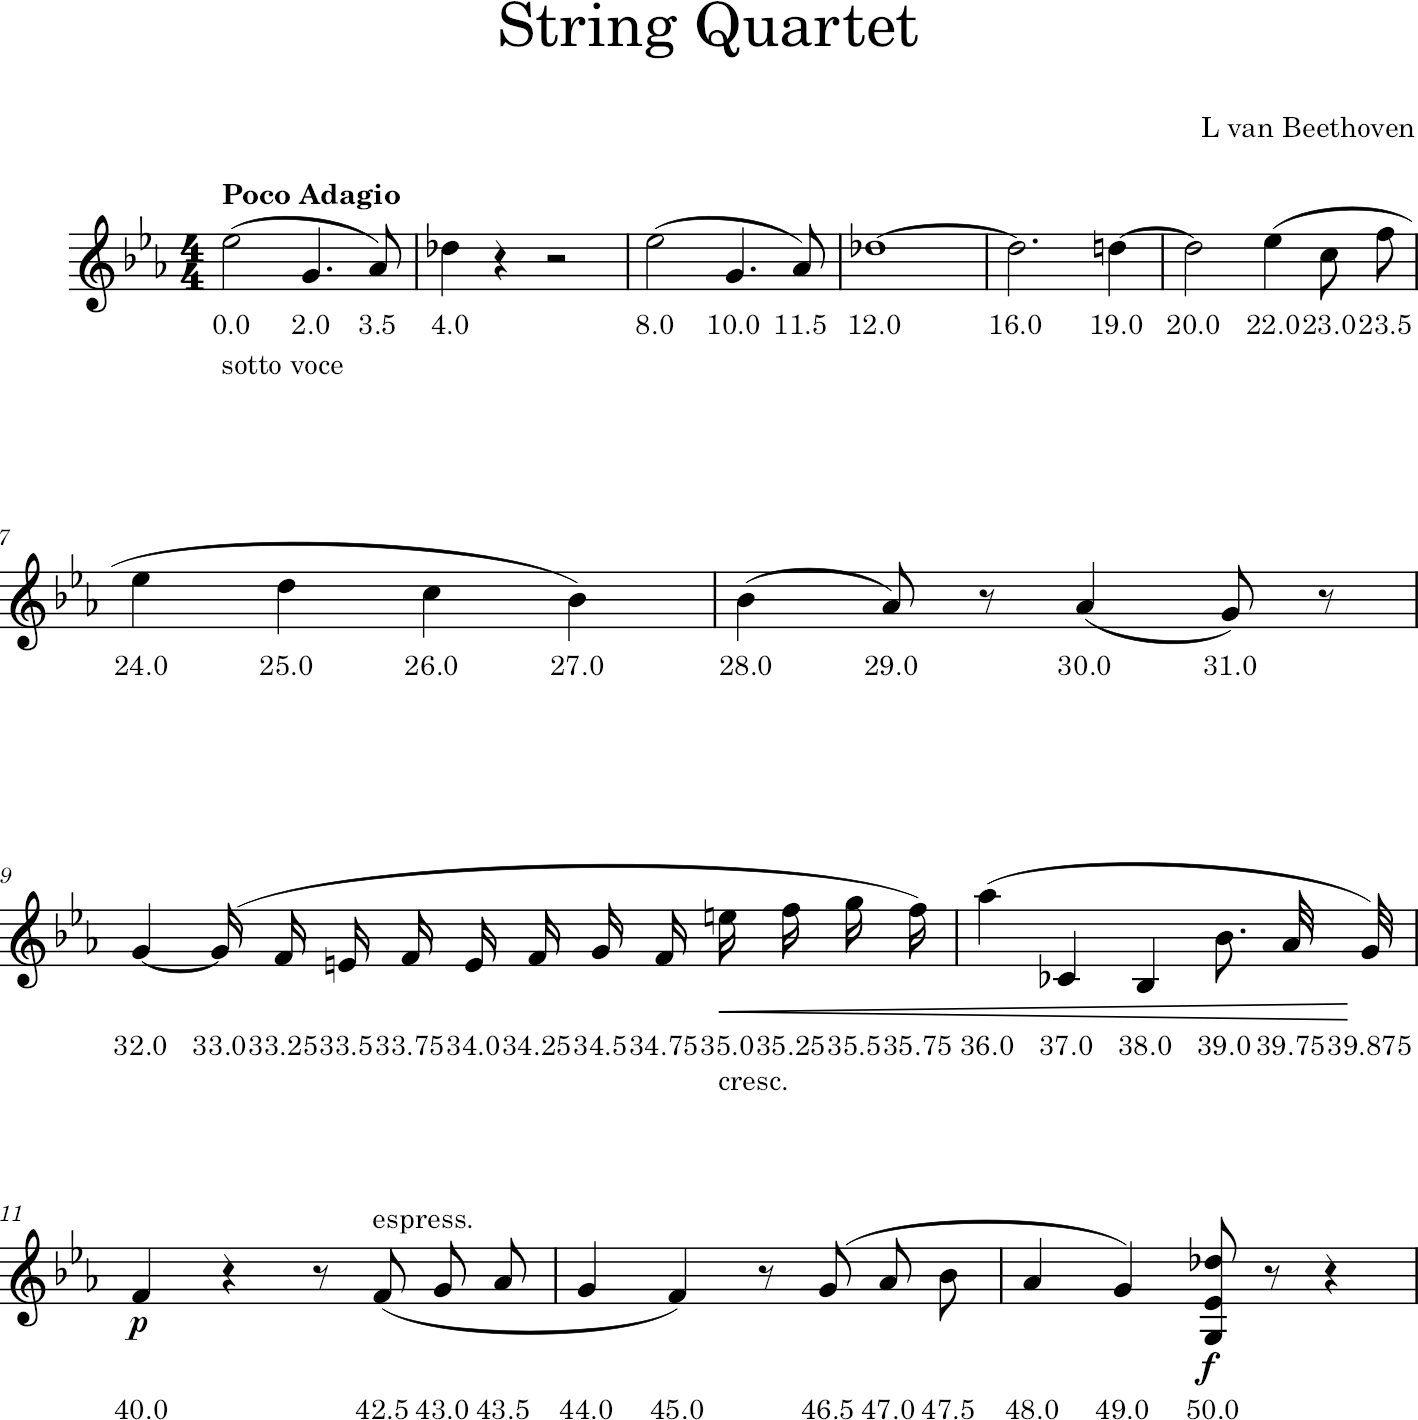

In [107]:
chosen = [7]

arrangement = stream.Stream()
for c in chosen:
    arrangement.mergeElements(phrases[c])

arrangement.show()
violin.show()

In [ ]:
test.parts[0].flatten().show("text")
test.parts[0].plot()

In [ ]:
test.plot("histogram", "pitchClass", dpi=600)

In [ ]:
beethoven = converter.parse("beethoven/opus74.mxl")